In [8]:
using Revise
using TaD
using DifferentialEquations, Flux, DiffEqFlux
using Plots
using LinearAlgebra
using SparseArrays
using IterativeSolvers

# Reconstructing Helix in 3D

In [9]:
function create_ūk(Qk::Vector{<:Float64})#, p::Integer = 3, num_samples::Integer = length(Qk) - p - 1) # n = m - p - 1, p = 3 
    """
    According to chord length method defined on pg 364
    """
    Qk_copy = copy(Qk)
    Qk_shift = copy(Qk)
    popfirst!(Qk_shift)
    pop!(Qk_copy)
    ūk = cumsum(broadcast(abs, Qk_shift - Qk_copy)) / sum(broadcast(abs, Qk_shift - Qk_copy))
    insert!(ūk, 1, 0)
    ūk
end

function create_knot_vector_new(Qk::Vector{<:Float64}, p::Integer = 3)
    ū = create_ūk(Qk)
    n = length(ū)
    m = length(ū) + p + 1
    kv = zeros(m)
    for j = 2:(n - p)
        kv[j+p] = sum(ū[j:(j+p-1)]) / float(p)
    end
    kv[(end - p):end] .= 1
    kv
end

function pow(x,y=2)
    return x^y
end

function generate_test_set((f1, f2), limit::Integer = 1, num::Integer = 100)
    t = LinRange(0, limit, num+1)
    dx = f1.(t)
    dy = f2.(t)
    dz = 1
    arr = zeros(Float64, (length(t), 3))
    arr[:, 1] = dx
    arr[:, 2] = dy
    arr[:, 3] = LinRange(0, 1, num+1)
    arr
end

generate_test_set (generic function with 3 methods)

# Trajectory Reconstruct 

In [10]:
#Knots = m
#From definition, m = n + p + 1
#set m = length(tangents) so the linear algebra works out
#then set n (num samples) = m - p - 1
function reconstruct_trajectory(tangents::Matrix{<:Float64}, number_of_control_points::Integer=(length(tangents) ÷ 2))
    control_points = zeros(size(tangents))
    control_points[:,1] = reconstruct_trajectory_1d(tangents[:,1])
    control_points[:,2] = reconstruct_trajectory_1d(tangents[:,2])
    control_points[:,3] = tangents[:,3]
    kv = create_knot_vector_new(tangents[:,1])
    basis = BSplineBasis(kv, 3, k=2)
    curve = BSplineCurve(basis, control_points)
    return curve
end

function return_zero_rows(A)
    row_zeros = map(is_row_zero, eachrow(A)) .*  collect(1:1:length(A[1,:]))
    row_zeros = row_zeros[row_zeros .> 0]
    return row_zeros
end

function is_row_zero(A)
    if length(findall(x -> x != 0, A)) == 0
        return 1
    end
    return 0
end

function reconstruct_trajectory_1d(tangents::Vector{<:Float64}, number_of_control_points::Integer=(length(tangents) ÷ 2))
    kv = create_knot_vector_new(tangents)
    ū = create_ūk(tangents) # n = m - p - 1
    basis = BSplineBasis(kv, 3, k=2)
    N, Nprime = construct_spline_matrix(basis, ū, length(kv), p)
    T = Nprime'*Nprime
    control_points = lsmr(N, tangents)
    return control_points
end

function construct_spline_matrix(basis::BSplineBasis, samples::Vector{<:Float64}, num_knots::Integer, p::Integer)
    rows, cols = length(samples), num_knots - p - 1
    N, Nprime = zeros(Float64, (rows, cols)), zeros(Float64, (rows, cols))
    N[1, 1] = 1
    N[end, end] = 1
    Nprime[1, 1] = 1
    Nprime[end, end] = 1
    for i in p:rows
        evals = basis(samples[i])
        column = find_knot_span(basis, samples[i])
        N[i,column-p:column] = evals[1,:]#evals[1, :][evals[1, :] .> 0]
        Nprime[i,column-p:column] = evals[2,:]#evals[2, :][evals[2, :] .> 0]
    end
    N, Nprime
end

construct_spline_matrix (generic function with 1 method)

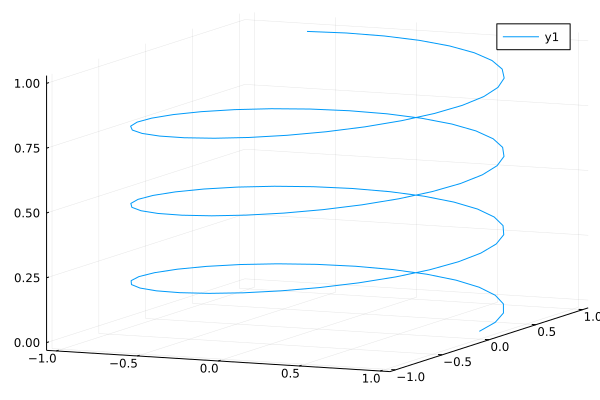

In [11]:
p = 3
Q = generate_test_set((cos, sin), 21, 100)

Curve = reconstruct_trajectory(Q)
plot((Q[:,1], Q[:,2], Q[:,3]))

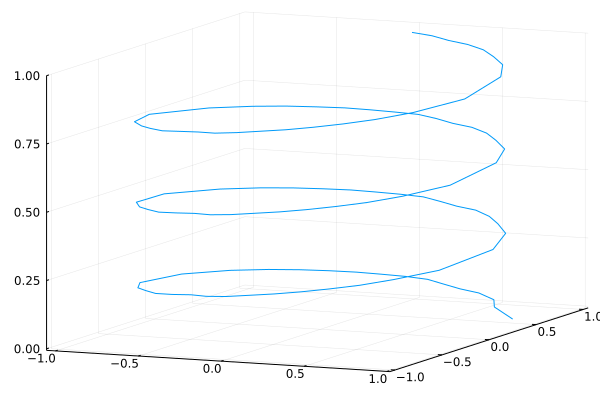

In [12]:
plot(Curve)